## Importing Data and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
Train = pd.read_csv('dataTrain.csv')
Test = pd.read_csv('dataTest.csv')

stats = pd.read_csv('stats.csv')
stats = stats.iloc[:,1:]

X_train = Train.drop('output', axis=1)
y_train = Train['output']

X_test = Test.drop('output', axis=1)
y_test = Test['output']

maxs = X_train.max().tolist()
mins = X_train.min().tolist()

var_names = X_train.columns.to_list()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((241, 12), (61, 12), (241,), (61,))

In [3]:
stats

,Feature,Mean,Variance
0,age,54.373444,83.926930
1,sex,0.651452,0.227062
2,cp,1.000000,1.070539
3,trtbps,130.784232,275.936847
4,chol,245.033195,2254.206367
5,fbs,0.132780,0.115150
6,restecg,0.526971,0.282468
7,thalachh,149.759336,495.798927
8,exng,0.302905,0.211153
9,oldpeak,0.978423,1.099368


In [4]:
savecols = X_train.columns

In [5]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.array
y_test = y_test.array

## Building the model

### Clustering

In this section, we will try out different numbers of clusters in order to minimize the separation between clusters. 

#### Functions

In [6]:
def SeparationMetric(X_train, clust_centers, part_matrix):
    metric = 0
    for clust in range(clust_centers.shape[0]):
        for point in range(X_train.shape[0]):
            metric += part_matrix[point, clust] * distance.euclidean(X_train[point], clust_centers[clust])
    return metric

#def SeparationMetric(X_train, clust_centers, part_matrix):
#    silhouette_score(X_train, )
#    return metric

In [7]:
# Since pyfume's clustering algorithm was using the the target, I made some modifcations to their fcm
# code as seen below

def fcm(data, n_clusters, m=2, max_iter=1000, error=0.005):
        #data: 2d array, size (N, S). N is the number of instances; S is the number of variables
        #n_clusters: number of clusters
        #m: fuzzy clustering coefficient
        #max_it: maximum number of iterations, default=1000
        #error: stopping criterion, default=0.005
        #seed: seed for random initialization of u matrix
        
    n_instances = data.shape[0]
        
    #randomly initaliaze u
    np.random.seed(1231241421)
    u = np.random.rand(n_instances, n_clusters)
    u = np.fmax(u, np.finfo(np.float64).eps)
    ut = u.T
        
    for it in range(0,max_iter):
        #copy old u matrix
        u_old = ut.copy()
        u_old /= np.ones((n_clusters, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
        u_old = np.fmax(u_old, np.finfo(np.float64).eps)
        
        #elevate to m
        um = u_old ** m
        
        #calculate cluster centers
        centers = um.dot(data) / (np.ones((data.shape[1], 1)).dot(np.atleast_2d(um.sum(axis=1))).T)
        
        #calculate distances
        dist = cdist(centers, data, metric='euclidean')
        dist = np.fmax(dist, np.finfo(np.float64).eps)
        
        #calculate objective
        jm = (um * dist ** 2).sum()
    
        #calculate new u matrix
        ut = dist ** (- 2. / (m - 1))
        ut /= np.ones((n_clusters, 1)).dot(np.atleast_2d(ut.sum(axis=0)))
    
        #stopping criterion
        if np.linalg.norm(ut - u_old) < error:
            break
    
    partition_matrix = ut.T
    return centers, partition_matrix

In [8]:
def Cluster(nclusters):
    clust_centers, part_matrix = fcm(X_train, n_clusters = nclusters)
    return clust_centers, part_matrix

In [9]:
def gaussian(x, mu, sig):
    return (1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2))

#### Code

In [10]:
max_clusters = 2
min_metric = np.inf

for i in range(max_clusters):
    i += 1
    clust_centers, part_matrix = Cluster(i)
    metric = SeparationMetric(X_train, clust_centers, part_matrix)
    if metric < min_metric:
        min_metric = metric
        best_number = i

print(f'Best number of clusters: {best_number}')

Best number of clusters: 2


In [11]:
clust_centers, part_matrix = Cluster(best_number)
clust_centers.shape, part_matrix.shape

((2, 12), (241, 2))

### Building the model

In [12]:
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
model = modbuilder.get_model()

 * Detected 2 rules / clusters
 * Detected Sugeno model type


### Inference and Metrics

In [13]:
modtester = SugenoFISTester(model, X_test, var_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs,axis=1)

In [14]:
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
rec_score = recall_score(y_test, y_pred)
print("Recall: {:.3f}".format(rec_score))
prec_score = precision_score(y_test, y_pred)
print("Precision Score: {:.3f}".format(prec_score))
F1_score = f1_score(y_test, y_pred)
print("F1-Score: {:.3f}".format(F1_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))

Accuracy: 0.836
Recall: 0.844
Precision Score: 0.844
F1-Score: 0.844
Kappa Score: 0.671


## Model Visualization/Interpretation

In [15]:
model._lvs['chol'] # example of how pyFUME defines une linguistic variable in simpful

<Linguistic variable 'chol', contains fuzzy sets [<Fuzzy set (function), term='cluster1'>, <Fuzzy set (function), term='cluster2'>], universe of discourse: None>

In [16]:
model.get_rules() # print the rules associated with the model

['IF ((sex IS cluster1) AND ((cp IS cluster1) AND ((trtbps IS cluster1) AND ((chol IS cluster1) AND ((fbs IS cluster1) AND ((restecg IS cluster1) AND ((thalachh IS cluster1) AND ((exng IS cluster1) AND ((oldpeak IS cluster1) AND ((slp IS cluster1) AND ((caa IS cluster1) AND (thall IS cluster1)))))))))))) THEN (OUTPUT IS fun1)',
 'IF ((sex IS cluster2) AND ((cp IS cluster2) AND ((trtbps IS cluster2) AND ((chol IS cluster2) AND ((fbs IS cluster2) AND ((restecg IS cluster2) AND ((thalachh IS cluster2) AND ((exng IS cluster2) AND ((oldpeak IS cluster2) AND ((slp IS cluster2) AND ((caa IS cluster2) AND (thall IS cluster2)))))))))))) THEN (OUTPUT IS fun2)']

In [17]:
# The pyFUME library doesn't atribute a universe of discourse to the linguistic variables it creates in simpful. In order to fix this, we set each universe considering the maximum
# value heald by each dataframe column. This has to be done since, otherwise, the plotting functions won't work.

for ix in range(len(var_names)):
    max = maxs[ix]
    min = mins[ix]
    uod = [min, max]
    model._lvs[var_names[ix]]._universe_of_discourse = uod


In [18]:
#model.produce_figure("",2)

## Converting the model to X

In [19]:
def UODtoX(model, stats):
    uods = {}
    for lv in model._lvs:
        data = stats[stats['Feature'] == lv]
        mean = data.iloc[0,1]
        std = data.iloc[0,2] ** 0.5
        uod = model._lvs[lv]._universe_of_discourse
        for i in range(2):
            uod[i] = uod[i] * std + mean
        uods[lv] = uod
    return uods

In [20]:
def FunctionstoX(model, stats):
    final_df = pd.DataFrame(columns = var_names+['constant'])

    for f in model._outputfunctions:
        acumulated = 0 # value to be added to the intercept in the end
        expression = model._outputfunctions[f]
        item_list = expression.split('+')

        for k in range(len(item_list) - 1):
            item_list[k] = item_list[k].split('*')
            values = stats[stats['Feature'] == item_list[k][1]]
            std = values.iloc[0,2] ** 0.5
            mean = values.iloc[0,1]
            acumulated += float(item_list[k][0]) * mean
            item_list[k] = float(item_list[k][0]) * (std) 
            
        item_list[-1] = float(item_list[-1]) + acumulated
        final_df = pd.concat([final_df,pd.DataFrame([item_list], columns = var_names+['constant'])], axis = 0)
        final_df.reset_index(drop=True, inplace=True)
    return final_df

In [21]:
class XMF:
    def __init__(self, uod, data, mu, sigma):
        self.uod = uod
        self.mean = data.iloc[0,1]
        self.std = data.iloc[0,2] ** 0.5
        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):
        x = x * self.std + self.mean
        x = gaussian(x, self.mu, self.sigma)
        return x
    

In [22]:
def newMFS(model, stats, uods):
    MFS = {}
    for lv in model._lvs:
        fs = []
        data = stats[stats['Feature'] == lv]
        uod = uods[lv]
        for clust in range(len(model._lvs[lv]._FSlist)):
            mu = model._lvs[lv]._FSlist[clust]._funpointer._mu
            sigma = model._lvs[lv]._FSlist[clust]._funpointer._sigma
            fs.append(XMF(uod, data, mu, sigma))
        MFS[lv] = fs
    return MFS

In [23]:
def plotMFs(mfs, var):
    mfs = mfs[var]
    x = np.linspace(mfs[0].uod[0], mfs[0].uod[1], 100)
    print(x)
    for i in range(len(mfs)):
        mu = mfs[i].mu
        sig = mfs[i].sigma
        print(-np.power((x - mu) / sig, 2.0) / 2)
        y = [mfs[i](j) for j in x]
        print(y)
        plt.plot(x, y)

In [24]:
uods = UODtoX(model, stats)
mfs = newMFS(model, stats, uods)
consequents = FunctionstoX(model, stats)

[131.         133.38383838 135.76767677 138.15151515 140.53535354
 142.91919192 145.3030303  147.68686869 150.07070707 152.45454545
 154.83838384 157.22222222 159.60606061 161.98989899 164.37373737
 166.75757576 169.14141414 171.52525253 173.90909091 176.29292929
 178.67676768 181.06060606 183.44444444 185.82828283 188.21212121
 190.5959596  192.97979798 195.36363636 197.74747475 200.13131313
 202.51515152 204.8989899  207.28282828 209.66666667 212.05050505
 214.43434343 216.81818182 219.2020202  221.58585859 223.96969697
 226.35353535 228.73737374 231.12121212 233.50505051 235.88888889
 238.27272727 240.65656566 243.04040404 245.42424242 247.80808081
 250.19191919 252.57575758 254.95959596 257.34343434 259.72727273
 262.11111111 264.49494949 266.87878788 269.26262626 271.64646465
 274.03030303 276.41414141 278.7979798  281.18181818 283.56565657
 285.94949495 288.33333333 290.71717172 293.1010101  295.48484848
 297.86868687 300.25252525 302.63636364 305.02020202 307.4040404
 309.787878

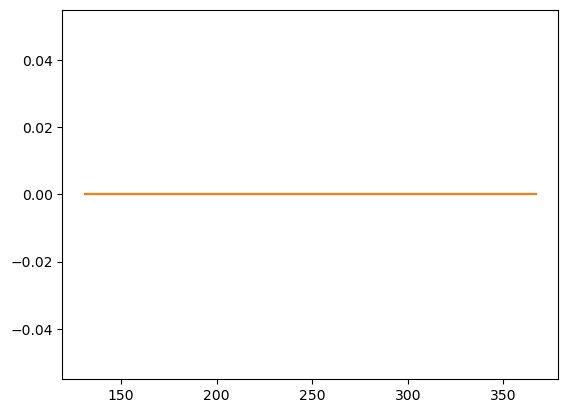

In [25]:
plotMFs(mfs, 'chol')